In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:100%; }")

In [2]:
from collections import deque
from graphviz import Digraph
from statistics import median
from time import process_time

# Splay Trees

In diesem Notebook wird eine bestimmte Art von selbstbalancierenden Bäumen gezeigt, die *Splay Trees*. Diese Datenstruktur wurde [1985 von Sleator und Tarjan eingeführt](http://www.cs.cmu.edu/~sleator/papers/self-adjusting.pdf "D. D. Sleator, R. E. Tarjan (1985): Self-Adjusting Binary Search Trees. Journal of the ACM, 32(3) 652-686"). Im Gegensatz zu anderen selbstbalancierenden Bäumen wie *AVL-Bäumen* wird bei Splay Trees nicht gefordert, dass der Baum zu allen Zeiten so gut wie möglich balanciert ist. Stattdessen wird der Baum dahingehend optimiert, dass häufig verwendete Elemente nahe an der Wurzel sind.

Auf Basis dieser Bäume soll später eine alternative Implementierung von Mengen in der Programmiersprache Python entstehen. In der Referenzimplementierung *CPython* sind [Mengen auf Basis von *Hashtabellen* implementiert](https://github.com/python/cpython/blob/41c57b335330ff48af098d47e379e0f9ba09d233/Objects/setobject.c "G. v. Rossum et al. (2019): cpython/Objects/setobject.c, GitHub"). Viele andere weit verbreitete Implementierungen anderer Programmiersprachen benutzen für Mengen ebenfalls Hashtabellen oder haben dies zumindest als Option, wie in [Java](https://docs.oracle.com/en/java/javase/13/docs/api/java.base/java/util/Set.html "Oracle Corp. (2019): Set (Java SE13 & JDK 13)"), [.NET (C#)](https://docs.microsoft.com/en-us/dotnet/api/system.collections.generic.iset-1?view=netframework-4.8, "Microsoft Corp. (2019): ISet<T> Interface (System.Collections.Generic), Microsoft Docs"), [JavaScript](https://v8.dev/blog/hash-code "Sathya Gunasekaran (2018): Optimizing hash tables: hiding the hash code, V8 Blog") oder [PHP](https://www.php.net/manual/en/class.ds-set.php "The PHP Group (2019): PHP: Set, Manual"). Jedoch macht die Verwendung von Bäumen für Mengen einige mengenlastige Programmierprobleme einfacher zu lösen, da diese Mengen *geordnet* sind und somit beispielsweise ein Minimum und ein Maximum haben.

Die reine Datenstruktur – ohne Operationen – ist bei Splay Trees genauso wie bei regulären geordneten binären Bäumen definiert: $\text{Node}(p, l, r)$ ist ein Baum, wobei
- $p$ eine Nutzlast (payload) ist,
- $l$ der linke Teilbaum ist und
- $r$ der rechte Teilbaum ist.

Zu diesem Zeitpunkt müssen wir alle Methodenrümpfe, die später verwendet werden, deklarieren. Später folgen die eigentlichen Definitionen dieser Methoden.

In [3]:
class Node:
    def __init__(self, payload, left, right):
        self.payload = payload
        self.left = left
        self.right = right
    
    def _splay(self, parent_stack, direction_stack):
        pass
    
    def _zig(self, parent):
        pass
    
    def _zag(self, parent):
        pass
    
    def _zig_zig(self, parent, grandparent):
        pass
    
    def _zag_zag(self, parent, grandparent):
        pass
    
    def _zig_zag(self, parent, grandparent):
        pass
    
    def _zag_zig(self, parent, grandparent):
        pass
    
    def _del_ret_max(self):
        pass
    
    def insert(self, payload):
        pass
    
    def delete(self, payload):
        pass
    
    def contains(self, payload):
        pass
    
    def show(self):
        pass
    
    def _show(self, dot, used, key):
        pass

Wir verlangen dabei:

- Für alle Nutzlasten aus dem linken Teilbaum $l$ gilt, dass sie kleiner als die Nutzlast $p$ sind.
- Für alle Nutzlasten aus dem rechten Teilbaum $r$ gilt, dass sie größer als die Nutzlast $p$ sind.

Diese Aussagen können auch als $l < p < r$ formuliert werden.

Die Betrachtung des Falls, dass eine Nutzlast in einem Teilbaum $l, r$ gleich der Nutzlast $p$ ist, entfällt, da Mengen keine doppelten Elemente enthalten. Diese Forderung impliziert außerdem, dass die Nutzlasten geordnet werden können. Wir behandeln später, wie wir beliebigen Nutzlasten in Python eine Ordnung geben können.

Wir definieren zunächst die Methode `show`, die einen Baum auf Basis von *GraphViz* visualisiert. Dies erleichtert später die Erklärungen anderer Operationen. `show` benutzt `_show`, eine Methode, die einem bestehenden Graphen die Knoten hinzufügt. `_show` nimmt zusätzlich eine Menge von benutzten Schlüsseln für die Knoten und einen Zähler, der Schlüssel für leere Blätter im Baum liefert.

In [4]:
def show(self):
    dot = Digraph()
    self._show(dot, set(), 0)
    return dot

def _show(self, dot, used, key):
    used.add(id(self))
    dot.node(str(id(self)), label=str(self.payload))
    if not (self.left is None and self.right is None):
        for node in self.left, self.right:
            if node is not None:
                dot.edge(str(id(self)), str(id(node)))
                used, key = node._show(dot, used, key)
            else:
                while True:
                    key += 1
                    if key not in used:
                        break
                used.add(key)
                dot.node(str(key), shape="point")
                dot.edge(str(id(self)), str(key))
    return (used, key)

Node.show = show
Node._show = _show
show = None
_show = None

## Splaying

Die Besonderheit von Splay Trees ist, dass nach allen Baumoperationen, die ein Element im Baum lokalisieren, eine besondere Operation, der *Splay*, durchgeführt wird. Mit Baumoperationen, die ein Element im Baum lokalisieren, sind alle Operationen auf den Baum gemeint, die den Baum auf der Suche nach einem Element oder auf der Suche nach dem richtigen Ort für ein Element durchsuchen. Dazu gehören das Einfügen, Löschen und Finden von Elementen.

Der Splay ist eine Funktion, die einen Baum dahingehend modifiziert, dass ein Knoten, der schon im Baum enthalten ist, die neue Wurzel des Baums wird:

$$\text{splay}: \text{Node} \times \text{Node} \to \text{Node}$$

Der Splay findet schrittweise statt, in jedem Schritt wird der zu splayende Knoten zwei Ebenen nach oben bewegt. Sollte der Knoten auf der zweitobersten Ebene sein, so wird er natürlich nur eine Ebene nach oben bewegt. Diesen Schritt behandeln wir zuerst. Ist der Knoten dabei das linke Kind seines Elternknotens, so bezeichnen wir diesen Schritt als *Zig*.

### Zig und Zag

Vor dem Schritt sieht der Baum wie folgt aus. Die Dreiecke zeigen dabei Teilbäume an.

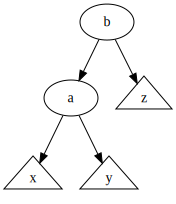

In [5]:
x = Node("x", None, None); y = Node("y", None, None); z = Node("z", None, None)
a = Node("a", x, y); b = Node("b", a, z)
dot = b.show()
for subtree in x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Wurzel, wobei $b$ das rechte Kind von $a$ wird, und der ehemals rechte Teilbaum von $a$, $y$, nun der linke Teilbaum von $b$ wird. Die Ordnung wird dabei nicht verletzt, denn

- $x$, $z$ sind weiterhin die gleichen Teilbäume ihrer bisherigen Eltern,
- $a < b$ und
- $y < b$ und $y > a$.

Formal definieren wir $\text{zig}()$ unter der Angabe des Elternknotens als Parameter als

$$\text{Node}(a, x, y).\text{zig}(\text{Node}(b, \_, z)) = \text{Node}(a, x, \text{Node}(b, y, z))$$

und in Code als

In [6]:
def _zig(self, parent):
    parent.left = self.right
    self.right = parent

Node._zig = _zig
_zig = None

Um das vergleichsweise teure Konstruieren neuer Objekte zu vermeiden, schreiben wir lediglich die Referenzen um. Nach dem Schritt sieht der Baum wie folgt aus:

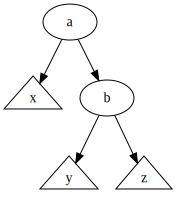

In [7]:
a._zig(b)
dot = a.show()
for subtree in x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

Ähnlich definieren wir *Zag*, bei dem der zu splayende Knoten das rechte Kind der Wurzel ist.

$$\text{Node}(a, y, z).\text{zag}(\text{Node}(b, x, \_) = \text{Node}(a, \text{Node}(b, x, y), z)$$

In [8]:
def _zag(self, parent):
    parent.right = self.left
    self.left = parent

Node._zag = _zag
_zag = None

### Zig-Zig und Zag-Zag

Als nächstes behandeln wir den Fall, dass der Knoten wenigstens zwei Ebenen von der Wurzel entfernt ist, und sowohl der Knoten als auch sein Elternknoten ein linkes Kind sind. Die Operation, die auf diese Ausgangssituation anzuwenden ist, bezeichnen wir als *Zig-Zig*. Diese Ausgangssituation sieht so aus:

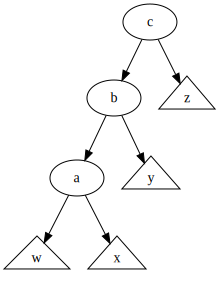

In [9]:
w = Node("w", None, None); x = Node("x", None, None); y = Node("y", None, None); z = Node("z", None, None)
a = Node("a", w, x); b = Node("b", a, y); c = Node("c", b, z)
dot = c.show()
for subtree in w, x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Stelle von $c$. Infolgedessen wird $b$ das linke Kind von $a$ und $c$ das linke Kind von $b$. $x$ wird der linke Teilbaum von $b$, $y$ der linke Teilbaum von $c$. Die Ordnungsbedingung bleibt erhalten:

- $w$, $z$ sind weiterhin die gleichen Teilbäume ihrer bisherigen Eltern,
- $a < b < c$ und
- $a < x < b$ und $b < y < c$.

Wir definieren unter Angabe von Elternknoten und Großelternknoten

$$\text{Node}(a, w, x).\text{zig_zig}(\text{Node}(b, \_, y), \text{Node}(c, \_, z)) = \text{Node}(a, w, \text{Node}(b, x, \text{Node}(c, y, z)))$$

und in Code

In [10]:
def _zig_zig(self, parent, grandparent):
    grandparent.left = parent.right
    parent.left = self.right
    parent.right = grandparent
    self.right = parent

Node._zig_zig = _zig_zig
_zig_zig = None

und haben visualisiert

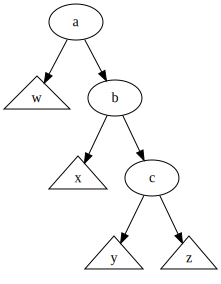

In [11]:
a._zig_zig(b, c)
dot = a.show()
for subtree in w, x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

Die möglichen Eltern von $c$ haben dann zwar temporär inkorrekte Referenzen, dies spielt aber, solange wir später nur ganze Splay-Operationen durchführen, keine Rolle, da diese Referenzen durch folgende Splay-Schritte aufgeräumt werden. Wir bezeichnen die gleiche Situation mit rechtem Kind und rechtem Enkel als *Zag-Zag*. Der Splay-Schritt ist ähnlich definiert.

$$\text{Node}(a, y, z).\text{zag_zag}(\text{Node}(b, x, \_), \text{Node}(c, w, \_)) = \text{Node}(a, \text{Node}(b, \text{Node}(c, w, x), y), z)$$

In [12]:
def _zag_zag(self, parent, grandparent):
    grandparent.right = parent.left
    parent.left = grandparent
    parent.right = self.left
    self.left = parent

Node._zag_zag = _zag_zag
_zag_zag = None

### Zig-Zag und Zag-Zig

Zuletzt behandeln wir den Fall, dass der Elternknoten ein linkes Kind, der Knoten selbst aber ein rechtes Kind ist. Die Operation auf diese Situation nennen wir *Zig-Zag*. Wir beginnen mit

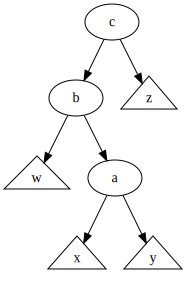

In [13]:
w = Node("w", None, None); x = Node("x", None, None); y = Node("y", None, None); z = Node("z", None, None)
a = Node("a", x, y); b = Node("b", w, a); c = Node("c", b, z)
dot = c.show()
for subtree in w, x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Stelle von $c$, dabei werden $b, c$ die Kinder von $a$. $x$ wird der rechte Teilbaum von $b$, $y$ der linke Teilbaum von $c$. Die Ordnungsbedingung bleibt erhalten:

- $w, z$ sind weiterhin die gleichen Teilbäume ihrer bisherigen Eltern,
- $b < a < c$ und
- $b < x < a$ und $a < y < c$.

Wir definieren

$$\text{Node}(a, x, y).\text{zig_zag}(\text{Node}(b, w, \_), \text{Node}(c, \_, z)) = \text{Node}(a, \text{Node}(b, w, x), \text{Node}(c, y, z))$$

und in Code

In [14]:
def _zig_zag(self, parent, grandparent):
    parent.right = self.left
    grandparent.left = self.right
    self.left = parent
    self.right = grandparent

Node._zig_zag = _zig_zag
_zig_zag = None

und haben visualisiert

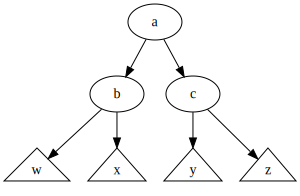

In [15]:
a._zig_zag(b, c)
dot = a.show()
for subtree in w, x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

In umgekehrter Reihenfolge, d.h. der Elternknoten ist das rechte Kind, der Knoten das linke Kind, haben wir die Operation *Zag-Zig* mit

$$\text{Node}(a, x, y).\text{zag_zig}(\text{Node}(b, \_, z), \text{Node}(c, w, \_)) = \text{Node}(a, \text{Node}(c, w, x), \text{Node}(b, y, z))$$

In [16]:
def _zag_zig(self, parent, grandparent):
    grandparent.right = self.left
    parent.left = self.right
    self.left = grandparent
    self.right = parent

Node._zag_zig = _zag_zig
_zag_zig = None

### Verkettung der Schritte

Das *Splayen* eines Knotens, also das Bewegen an die Wurzel, funktioniert durch das wiederholte Durchführen der Zig-, Zig-Zig- und Zig-Zag-Schritte (und umgekehrt), bis der Knoten an der Wurzel angelangt ist. Wir fordern dabei, dass schon bekannt ist, wie sich die Kette von Eltern des zu splayenden Knotens bis hoch zur Wurzel zusammensetzt. Ebenso soll pro Ebene bekannt sein, auf welcher Seite das entsprechende Kind ist. Dies erspart Überprüfungen, wenn entschieden werden soll, welcher Schritt als nächstes durchzuführen ist. Diese Stapel müssen vor dem Splay aufgebaut werden, also bei einer Operation, die den Weg bis zu dem Knoten herunterfindet.

Falls noch genau ein Knoten auf dem Stapel der Eltern liegt, so wissen wir schon, dass wir Zig oder Zag durchführen müssen. In diesem Fall unterscheiden wir:

|Linkes Kind|Rechtes Kind|
|-----------|------------|
|Zig        |Zag         |

Falls noch mindestens zwei Knoten auf dem Stapel der Eltern liegen, so unterscheiden wir:

|                 |Linkes Kind|Rechtes Kind|
|-----------------|-----------|------------|
|**Linker Enkel** |Zig-Zig    |Zig-Zag     |
|**Rechter Enkel**|Zag-Zig    |Zag-Zag     |

oder formaler:

- $\text{parent} := \text{parent_stack}.\text{pop}(); \text{parent_stack}.\text{is_empty}() \land \text{direction_stack}.\text{pop}() = \text{left} \Rightarrow \text{Node}.\text{splay_step}() = \text{Node}.\text{zig}(\text{parent})$
- $\text{parent} := \text{parent_stack}.\text{pop}(); \text{parent_stack}.\text{is_empty}() \land \text{direction_stack}.\text{pop}() = \text{right} \Rightarrow \text{Node}.\text{splay_step}() = \text{Node}.\text{zag}(\text{parent})$
- $\text{parent} := \text{parent_stack}.\text{pop}(); \text{direction_stack}.\text{pop}() = \text{left} \land \lnot \text{parent_stack}.\text{is_empty}(); \text{grandparent} := \text{parent_stack}.\text{pop}(); \text{direction_stack}.\text{pop}() = \text{left} \Rightarrow \text{Node}.\text{splay_step}() = \text{Node}.\text{zig_zig}(\text{parent}, \text{grandparent})$
- $\text{parent} := \text{parent_stack}.\text{pop}(); \text{direction_stack}.\text{pop}() = \text{right} \land \lnot \text{parent_stack}.\text{is_empty}(); \text{grandparent} := \text{parent_stack}.\text{pop}(); \text{direction_stack}.\text{pop}() = \text{right} \Rightarrow \text{Node}.\text{splay_step}() = \text{Node}.\text{zag_zag}(\text{parent}, \text{grandparent})$
- $\text{parent} := \text{parent_stack}.\text{pop}(); \text{direction_stack}.\text{pop}() = \text{right} \land \lnot \text{parent_stack}.\text{is_empty}(); \text{grandparent} := \text{parent_stack}.\text{pop}(); \text{direction_stack}.\text{pop}() = \text{left} \Rightarrow \text{Node}.\text{splay_step}() = \text{Node}.\text{zig_zag}(\text{parent}, \text{grandparent})$
- $\text{parent} := \text{parent_stack}.\text{pop}(); \text{direction_stack}.\text{pop}() = \text{left} \land \lnot \text{parent_stack}.\text{is_empty}(); \text{grandparent} := \text{parent_stack}.\text{pop}(); \text{direction_stack}.\text{pop}() = \text{right} \Rightarrow \text{Node}.\text{splay_step}() = \text{Node}.\text{zag_zig}(\text{parent}, \text{grandparent})$

Die Schritte werden bis zur Erschöpfung der Stapel wiederholt, oder formal:

- $\lnot \text{parent_stack}.\text{is_empty}() \Rightarrow \text{Node}.\text{splay}() = \text{Node}.\text{splay_step}().\text{splay}()$
- $\text{parent_stack}.\text{is_empty}() \Rightarrow \text{Node}.\text{splay}() = \text{Node}$

Die Implementierung halten wir *iterativ*, um Funktionsaufrufe und Grenzen von Rekursionstiefe zu vermeiden:

In [17]:
def _splay(self, parent_stack, direction_stack):
    while parent_stack:  # deque is not empty
        parent = parent_stack.pop()
        is_left_child = direction_stack.pop()
        if not parent_stack:  # deque is empty
            if is_left_child:
                self._zig(parent)
            else:
                self._zag(parent)
        else:
            grandparent = parent_stack.pop()
            is_left_grandchild = direction_stack.pop()
            if is_left_child and is_left_grandchild:
                self._zig_zig(parent, grandparent)
            elif not is_left_child and not is_left_grandchild:
                self._zag_zag(parent, grandparent)
            elif not is_left_child and is_left_grandchild:
                self._zig_zag(parent, grandparent)
            else:
                self._zag_zig(parent, grandparent)

Node._splay = _splay
_splay = None

Das nächste Beispiel zeigt, wie ein Splay aus einem schlechtestmöglich balancierten Baum einen deutlich besser balancierten Baum machen kann:

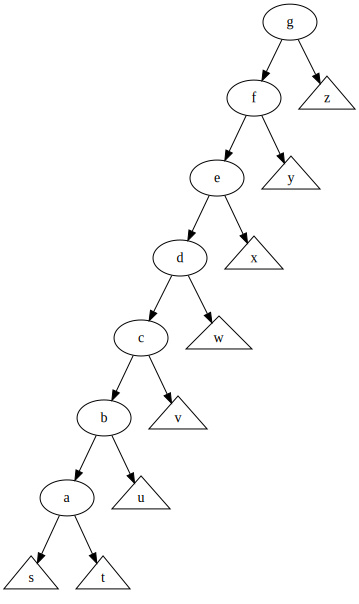

In [18]:
s = Node("s", None, None); t = Node("t", None, None); u = Node("u", None, None); v = Node("v", None, None)
w = Node("w", None, None); x = Node("x", None, None); y = Node("y", None, None); z = Node("z", None, None)
a = Node("a", s, t); b = Node("b", a, u); c = Node("c", b, v); d = Node("d", c, w)
e = Node("e", d, x); f = Node("f", e, y); g = Node("g", f, z)
dot = g.show()
for subtree in s, t, u, v, w, x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

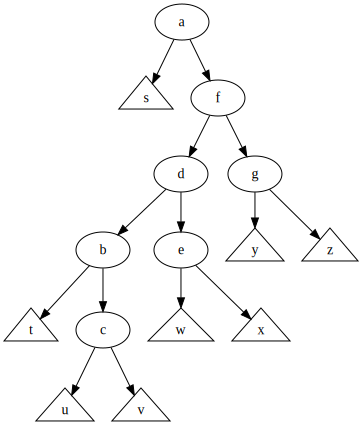

In [19]:
a._splay(deque([g, f, e, d, c, b]), deque([True] * 6))
dot = a.show()
for subtree in s, t, u, v, w, x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

Ein anderes Beispiel enthält alle Schritte außer Zag:

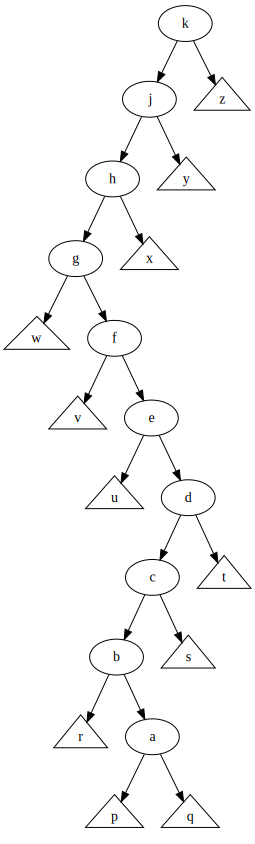

In [20]:
p = Node("p", None, None); q = Node("q", None, None); r = Node("r", None, None); s = Node("s", None, None)
t = Node("t", None, None); u = Node("u", None, None); v = Node("v", None, None); w = Node("w", None, None)
x = Node("x", None, None); y = Node("y", None, None); z = Node("z", None, None)
a = Node("a", p, q); b = Node("b", r, a); c = Node("c", b, s); d = Node("d", c, t); e = Node("e", u, d)
f = Node("f", v, e); g = Node("g", w, f); h = Node("h", g, x); j = Node("j", h, y); k = Node("k", j, z)
dot = k.show()
for subtree in p, q, r, s, t, u, v, w, x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

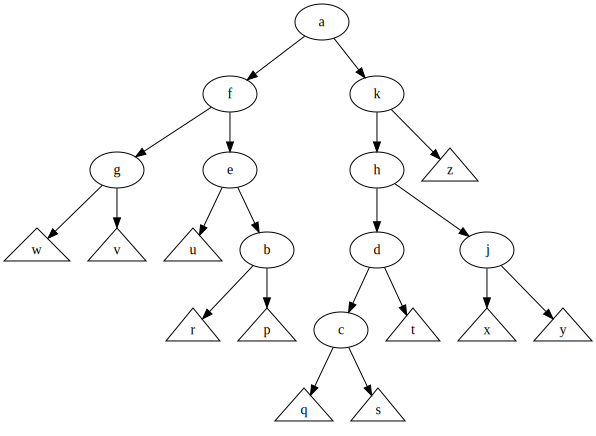

In [21]:
a._splay(deque([k, j, h, g, f, e, d, c, b]), deque([True, True, True, False, False, False, True, True, False]))
dot = a.show()
for subtree in p, q, r, s, t, u, v, w, x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir betrachten zuletzt das folgende Beispiel, um Zag abgedeckt zu haben:

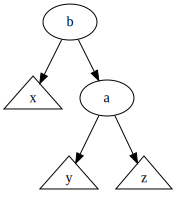

In [22]:
x = Node("x", None, None); y = Node("y", None, None); z = Node("z", None, None)
a = Node("a", y, z); b = Node("b", x, a)
dot = b.show()
for subtree in x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

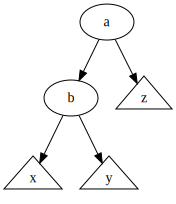

In [23]:
a._splay(deque([b]), deque([False]))
dot = a.show()
for subtree in x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

Schließlich definieren wir `_splay()` so, dass die Routinen für die einzelnen Schritte nicht in eigenen Methoden aufgerufen werden, um Aufrufe zu sparen.

In [24]:
def _splay(self, parent_stack, direction_stack):
    while parent_stack:
        parent = parent_stack.pop()
        is_left_child = direction_stack.pop()
        if not parent_stack:  # deque is empty
            if is_left_child:
                parent.left = self.right
                self.right = parent
            else:
                parent.right = self.left
                self.left = parent
        else:
            grandparent = parent_stack.pop()
            is_left_grandchild = direction_stack.pop()
            if is_left_child and is_left_grandchild:
                grandparent.left = parent.right
                parent.left = self.right
                parent.right = grandparent
                self.right = parent
            elif not is_left_child and is_left_grandchild:
                parent.right = self.left
                grandparent.left = self.right
                self.left = parent
                self.right = grandparent
            elif not is_left_child and not is_left_grandchild:
                grandparent.right = parent.left
                parent.left = grandparent
                parent.right = self.left
                self.left = parent
            else:
                grandparent.right = self.left
                parent.left = self.right
                self.left = grandparent
                self.right = parent

Node._splay = _splay
_splay = None

## Standardoperationen

Wir definieren für den Splay Tree als nächstes die grundlegenden Operationen auf Bäume: Einfügen, Löschen, auf das Vorhandensein eines Elements überprüfen, und auf das Leersein überprüfen. Wir bezeichnen im Folgenden den leeren Baum als $\text{Nil}$.

### Einfügen

Einfügen in einen Splay Tree funktioniert grundsätzlich genau wie das Einfügen in einen normalen geordneten binären Baum. Dabei müssen wir allerdings die Stapel von Elternreferenzen und Richtungen aufbauen.

Diese Stapel müssen wir zuerst konstruieren. Der erste Schritt lautet daher:

$$\text{Node} \neq \text{Nil} \Rightarrow \text{Node}.\text{insert}(p') = \text{Node}.\text{insert}(p', \text{Stack}(), \text{Stack}())$$

oder, für den leeren Baum:

$$\text{Node} = \text{Nil} \Rightarrow \text{Node}.\text{insert}(p') = \text{Node}(p', \text{Nil}, \text{Nil})$$

Falls im anderen Fall die Nutzlast schon im Baum existiert, ist nur der gefundene Knoten zu splayen:

$$p' = p \Rightarrow \text{Node}(p, l, r) =: x; x.\text{insert}(p', \text{parent_stack}, \text{direction_stack}) = x.\text{splay}(\text{parent_stack}, \text{direction_stack})$$

Falls die neue Nutzlast im Falle eines leeren Blattes eingesetzt werden kann, ist sie dort zu platzieren und der neue Knoten ist zu splayen:

$$p' < p \land l = \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{insert}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p', \text{Nil}, \text{Nil}).\text{splay}(\text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{left})$$
$$p' > p \land r = \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{insert}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p', \text{Nil}, \text{Nil}).\text{splay}(\text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{right})$$

Dabei müssen wir das Setzen des neuen Knotens als Kind nicht in die Definition aufnehmen, weil sich das schon durch den entsprechenden Splay ergibt.

Ansonsten haben wir die rekursiven Fälle:

$$p' < p \land l \neq \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{insert}(p', \text{parent_stack}, \text{direction_stack}) = l.\text{insert}(p', \text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{left}))$$
$$p' > p \land r \neq \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{insert}(p', \text{parent_stack}, \text{direction_stack}) = r.\text{insert}(p', \text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{right}))$$

Wir benutzen wieder eine iterative Implementierung und überschreiben im rekursiven Fall einfach immer das gerade betrachtete Objekt.

In [25]:
def insert(self, payload):
    parent_stack = deque()
    direction_stack = deque()
    while True:
        if payload < self.payload:
            if self.left is None:
                leaf = Node(payload, None, None)
                parent_stack.append(self)
                direction_stack.append(True)
                leaf._splay(parent_stack, direction_stack)
                # new node is root after splay
                return leaf
            else:
                parent_stack.append(self)
                direction_stack.append(True)
                self = self.left
        elif payload == self.payload:
            self._splay(parent_stack, direction_stack)
            return self
        else:
            if self.right is None:
                leaf = Node(payload, None, None)
                parent_stack.append(self)
                direction_stack.append(False)
                leaf._splay(parent_stack, direction_stack)
                return leaf
            else:
                parent_stack.append(self)
                direction_stack.append(False)
                self = self.right

Node.insert = insert
insert = None

Wir definieren – unter anderem zur Betrachtung des Falls des leeren Baumes – die Klasse `SplayTree`, die das Management des leeren Baums wie auch der Tatsache, dass sich bei einem Splay die Wurzel ändert, nach außen vereinfacht.

In [26]:
class SplayTree:
    def __init__(self):
        self.tree = None
    
    def insert(self, payload):
        if self.tree is None:
            self.tree = Node(payload, None, None)
        else:
            self.tree = self.tree.insert(payload)
    
    def delete(self, payload):
        pass
    
    def contains(self, paylaod):
        pass
    
    def is_empty(self):
        pass
    
    def show(self):
        return self.tree.show()

Einige Beispiele zeigen das Einsetzen von Knoten in Splay Trees:

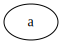

In [27]:
my_splay = SplayTree()
my_splay.insert("a")
my_splay.show()

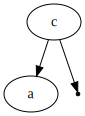

In [28]:
my_splay.insert("c")
my_splay.show()

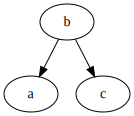

In [29]:
my_splay.insert("b")
my_splay.show()

### Entfernen

Wir definieren als nächstes das Entfernen eines Elementes. Wir konstruieren wieder zunächst die Stapel.

$$\text{Node} \neq \text{Nil} \Rightarrow \text{Node}.\text{delete}(p') = \text{Node}.\text{delete}(p', \text{Stack}(), \text{Stack}())$$

Beim leeren Baum gibt es nichts zu tun.

$$\text{Node} = \text{Nil} \Rightarrow \text{Node}.\text{delete}(p') = \text{Nil}$$

Wir behandeln zunächst den Fall, in dem wir den zu löschenden Knoten gefunden haben und mindestens eines der Kinder dieses Knotens leer ist. Dann kann der andere Teilbaum einfach an diese Stelle gezogen werden. Darauf wird der Elternknoten des gelöschten Knotens gesplayt.

$p' = p \land l = \text{Nil} \land \lnot \text{parent_stack}.\text{is_empty}() \land \text{parent_stack}.\text{pop}() = \text{Node}(p^*, l^*, r^*) \land \text{direction_stack}.\text{pop}() = \text{left} \Rightarrow$
$$\text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p^*, r, r^*).\text{splay}(\text{parent_stack}, \text{direction_stack})$$
$p' = p \land l = \text{Nil} \land \lnot \text{parent_stack}.\text{is_empty}() \land \text{parent_stack}.\text{pop}() = \text{Node}(p^*, l^*, r^*) \land \text{direction_stack}.\text{pop}() = \text{right} \Rightarrow$
$$\text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p^*, l^*, r).\text{splay}(\text{parent_stack}, \text{direction_stack})$$
$p' = p \land l \neq \text{Nil} \land r = \text{Nil} \land \lnot \text{parent_stack}.\text{is_empty}() \land \text{parent_stack}.\text{pop}() = \text{Node}(p^*, l^*, r^*) \land \text{direction_stack}.\text{pop}() = \text{left} \Rightarrow$
$$\text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p^*, l, r^*).\text{splay}(\text{parent_stack}, \text{direction_stack})$$
$p' = p \land l \neq \text{Nil} \land r = \text{Nil} \land \lnot \text{parent_stack}.\text{is_empty}() \land \text{parent_stack}.\text{pop}() = \text{Node}(p^*, l^*, r^*) \land \text{direction_stack}.\text{pop}() = \text{right} \Rightarrow$
$$\text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p^*, l^*, l).\text{splay}(\text{parent_stack}, \text{direction_stack})$$

Sollte dies an der Wurzel passieren, so ist der Knoten ohne Splay hochzuziehen.

$$p' = p \land l = \text{Nil} \land \text{parent_stack}.\text{is_empty}() \Rightarrow \text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = r$$
$$p' = p \land l \neq \text{Nil} \land r = \text{Nil} \land \text{parent_stack}.\text{is_empty}() \Rightarrow \text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = l$$

Schwieriger wird es, wenn der zu löschende Knoten zwei nichtleere Teilbäume hat. Dann setzen wir an die Stelle des zu löschenden Knotens das Maximum seines linken Teilbaums. Die Orndungsbedingung wird nicht verletzt, weil das Maximum des linken Teilbaums größer ist als alle Elemente des linken Teilbaums, aber kleiner als alle Elemente des rechten Teilbaums.

Wir definieren dafür $\text{del_ret_max}()$ (delete and return maximum). Die Funktion gibt ein Tupel von dem Maximum und dem neuen Baum zurück.

$$r = \text{Nil} \Rightarrow \text{Node}(p, l, r).\text{del_ret_max}() = (p, l)$$
$$r \neq \text{Nil} \land r.\text{del_ret_max}() = (p', r') \Rightarrow \text{Node}(p, l, r).\text{del_ret_max}() = (p', \text{Node}(p, l, r'))$$

Dann können wir beliebige Knoten entfernen mit

$p' = p \land l \neq \text{Nil} \land r \neq \text{Nil} \land \text{parent_stack}.\text{pop}() = \text{Node}(p^*, l^*, r^*) \land \text{direction_stack}.\text{pop}() = \text{left} \land l.\text{del_ret_max}() = (\tilde{p}, \tilde{l}) \Rightarrow$
$$\text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p^*, \text{Node}(\tilde{p}, \tilde{l}, r), r^*).\text{splay}(\text{parent_stack}, \text{direction_stack})$$
$p' = p \land l \neq \text{Nil} \land r \neq \text{Nil} \land \text{parent_stack}.\text{pop}() = \text{Node}(p^*, l^*, r^*) \land \text{direction_stack}.\text{pop}() = \text{right} \land l.\text{del_ret_max}() = (\tilde{p}, \tilde{l}) \Rightarrow$
$$\text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p^*, l^*, \text{Node}(\tilde{p}, \tilde{l}, r)).\text{splay}(\text{parent_stack}, \text{direction_stack})$$

Bei den rekursiven Fällen haben wir:

$$p' < p \land l \neq \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = l.\text{delete}(p', \text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{left}))$$
$$p' > p \land r \neq \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = r.\text{delete}(p', \text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{right}))$$

Schlussendlich ändern wir nichts, wenn der Knoten nicht existiert:

$$p' < p \land l = \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{parent_stack}.\text{push}(x).\text{bottom}()$$
$$p' > p \land r = \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{parent_stack}.\text{push}(x).\text{bottom}()$$

Wir benutzen wieder iterative Implementierungen.

In [30]:
def _del_ret_max(self):
    if self.right is None:
        return (self.payload, self.left)
    root = self
    while True:
        if self.right.right is None:
            maximum = self.right.payload
            self.right = self.right.left
            return (maximum, root)
        else:
            self = self.right

Node._del_ret_max = _del_ret_max
_del_ret_max = None

def delete(self, payload):
    parent_stack = deque()
    direction_stack = deque()
    while True:
        if payload < self.payload:
            if self.left is None:
                parent_stack.append(self)
                return parent_stack[0]
            else:
                parent_stack.append(self)
                direction_stack.append(True)
                self = self.left
        elif payload == self.payload:
            if not parent_stack:
                if self.left is None:
                    return self.right
                elif self.right is None:
                    return self.left
                else:
                    self.payload, self.left = self.left._del_ret_max()
                    return self
            parent = parent_stack.pop()
            is_left_child = direction_stack.pop()
            if self.left is None:
                if is_left_child:
                    parent.left = self.right
                else:
                    parent.right = self.right
            elif self.right is None:
                if is_left_child:
                    parent.left = self.left
                else:
                    parent.right = self.left
            else:
                self.payload, self.left = self.left._del_ret_max()
            parent._splay(parent_stack, direction_stack)
            return parent
        else:
            if self.right is None:
                parent_stack.append(self)
                return parent_stack[0]
            else:
                parent_stack.append(self)
                direction_stack.append(False)
                self = self.right

Node.delete = delete
delete = None

def delete(self, payload):
    if self.tree is not None:
        self.tree = self.tree.delete(payload)

SplayTree.delete = delete
delete = None

Einige Beispiele zeigen das Entfernen von Elementen.

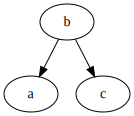

In [31]:
my_splay = SplayTree()
for letter in ["a", "c", "b"]:
    my_splay.insert(letter)
my_splay.show()

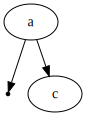

In [32]:
my_splay.delete("b")
my_splay.show()

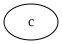

In [33]:
my_splay.delete("a")
my_splay.show()

### Finden

Wir definieren als nächstes das Überprüfen eines Baumes auf ein Element. Im Vergleich zu dieser Operation auf einem normalen geordneten binären Baum wird auch hier das gefundene Element gesplayt. In unserer Definition wird ein Tupel aus dem Vorhandensein und der neuen Wurzel zurückgegeben.

Wir konstruieren die Stapel (oder hören sofort auf, wenn der Baum leer ist):

$$\text{Node} \neq \text{Nil} \Rightarrow \text{Node}.\text{contains}(p') = \text{Node}.\text{contains}(p', \text{Stack}(), \text{Stack}())$$
$$\text{Node} = \text{Nil} \Rightarrow \text{Node}.\text{contains}(p') = (\text{false}, \text{Nil})$$

Wir bestätigen das Vorhandensein, wenn der Knoten gefunden ist, und splayen:

$$p' = p \Rightarrow \text{Node}(p, l, r) =: x; x.\text{contains}(p', \text{parent_stack}, \text{direction_stack}) = (\text{true}, x.\text{splay}(\text{parent_stack}, \text{direction_stack}))$$

Wir verneinen das Vorhandensein, wenn der Knoten nicht existieren kann:

$$p' < p \land l = \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{contains}(p', \text{parent_stack}, \text{direction_stack}) = (\text{false}, \text{parent_stack}.\text{push}(x).\text{bottom}())$$
$$p' > p \land r = \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{contains}(p', \text{parent_stack}, \text{direction_stack}) = (\text{false}, \text{parent_stack}.\text{push}(x).\text{bottom}())$$

Wir gehen tiefer in den Baum, wenn der Knoten in dem entsprechenden Teilbaum sein könnte:

$$p' < p \land l \neq \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{contains}(p', \text{parent_stack}, \text{direction_stack}) = l.\text{contains}(\text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{left}))$$
$$p' > p \land r \neq \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{contains}(p', \text{parent_stack}, \text{direction_stack}) = r.\text{contains}(\text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{right}))$$

Wir implementieren wieder iterativ:

In [34]:
def contains(self, payload):
    parent_stack = deque()
    direction_stack = deque()
    while True:
        if payload < self.payload:
            if self.left is None:
                parent_stack.append(self)
                return (False, parent_stack[0])
            else:
                parent_stack.append(self)
                direction_stack.append(True)
                self = self.left
        elif payload == self.payload:
            self._splay(parent_stack, direction_stack)
            return (True, self)
        else:
            if self.right is None:
                parent_stack.append(self)
                return (False, parent_stack[0])
            else:
                parent_stack.append(self)
                direction_stack.append(False)
                self = self.right

Node.contains = contains
contains = None

def contains(self, payload):
    if self.tree is not None:
        contains, self.tree = self.tree.contains(payload)
        return contains
    else:
        return False

SplayTree.contains = contains
contains = None

Beispiele zeigen uns:

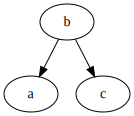

In [35]:
my_splay = SplayTree()
for letter in ["a", "c", "b"]:
    my_splay.insert(letter)
my_splay.show()

In [36]:
my_splay.contains("a")

True

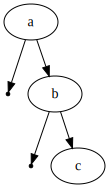

In [37]:
my_splay.show()

In [38]:
my_splay.contains("d")

False

### Leerüberprüfung

Wir definieren zuletzt, wie wir überprüfen, ob der Baum leer ist.

$$\text{Node} = \text{Nil} \Rightarrow \text{Node}.\text{is_empty}() = \text{true}$$
$$\text{Node} \neq \text{Nil} \Rightarrow \text{Node}.\text{is_empty}() = \text{false}$$

Die Implementierung findet von `SplayTree` aus statt.

In [39]:
def is_empty(self):
    return self.tree is None

SplayTree.is_empty = is_empty
is_empty = None

In [40]:
my_splay = SplayTree()
my_splay.is_empty()

True

In [41]:
my_splay.insert("a")
my_splay.is_empty()

False

## Anwendungsbeispiel: Sieb des Eratosthenes

Als Anwendungsbeispiel benutzen wir den `SplayTree` als Menge, um alle Primzahlen bis zu einem Maximum abzulegen. Die Primzahlen werden dabei mit dem Sieb des Eratosthenes berechnet. Die Implementierung ist sehr einfach gehalten und hat Raum für Optimierungen, aber das ist für den Vergleich mit `set` unproblematisch.

In [42]:
def splay_primes(n):
    primes = SplayTree()
    for i in range(2, n + 1):
        primes.insert(i)
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            primes.delete(j)
    return primes

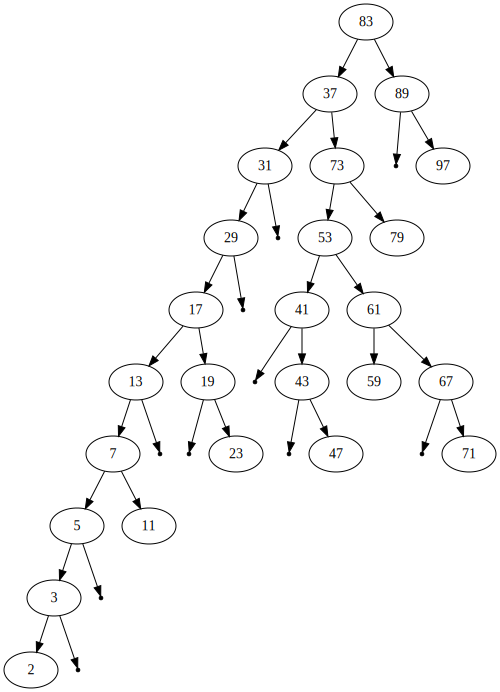

In [43]:
splay_primes(100).show()

Wir wiederholen die Implementierung mit dem eingebauten `set`.

In [44]:
def set_primes(n):
    primes = set(range(2, n + 1))
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            primes -= set([j])
    return primes

In [45]:
print(set_primes(100))

{2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97}


Wir betrachten nun vergleichend die Ausführungszeiten beider Varianten.

In [46]:
splay_times = []
set_times = []

for i in range(10):
    start = process_time()
    splay_primes(10**4)
    stop = process_time()
    splay_times.append(stop - start)
    
    start = process_time()
    set_primes(10**4)
    stop = process_time()
    set_times.append(stop - start)

splay_median = median(splay_times)
set_median = median(set_times)
print(f"Median time of splay-based primes was {round(splay_median, 5)}s")
print(f"Median time of builtin set-based primes was {round(set_median, 5)}s")
if splay_median > set_median:
    print(f"Splaying was {round(splay_median / set_median, 2)} times slower")
else:
    print(f"Splaying was {round(set_median / splay_median, 2)} times faster")

Median time of splay-based primes was 1.42217s
Median time of builtin set-based primes was 0.02479s
Splaying was 57.36 times slower


Dabei ist zu beachten, dass wir zu diesem Zeitpunkt die Python-Implementierung mit einer C-Implementierung vergleichen.